# Automatic sleep stage classification with CNN and LSTM   


## Classifiers 

This is the second of 3 notebooks for Automatic sleep stage classification with CNN and LSTM.

The general purpose of the 3 notebooks is to extract data from Sleep EDF database and perform sleep classification with CNN and LSTM techniques. 

Some parts of the work have been adapted from the paper published by Supratak et al. and its corresponding code available at (https://github.com/akaraspt/deepsleepnet).

For best reproducibility effects, I recommend to run all code in a Google Colab environment with an active GPU hardware accelerator.

This second notebook has the next sections:
* I. Libraries and data load
* II. CNN Concat
* III. CNN + LSTM
* IV. Hypnogram comparison



# I. Libraries and data load

Libraries and functions that will be needed. Loading of the NPZ files generated in the first notebook.

In [1]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time
from datetime import datetime as dt
import pandas as pd
import os
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import Normalizer




#Functions

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

def _load_npz_file(npz_file):
    """Load data and labels from a npz file."""
    with np.load(npz_file) as f:
        data = f["x"]
        labels = f["y"]
        sampling_rate = f["fs"]
    return data, labels, sampling_rate

def _load_npz_list_files(npz_files):
    """Load data and labels from list of npz files."""
    data = []
    labels = []
    fs = None
    for npz_f in npz_files:
        tmp_data, tmp_labels, sampling_rate = _load_npz_file(npz_f)
        if fs is None:
            fs = sampling_rate
        elif fs != sampling_rate:
            raise Exception("Found mismatch in sampling rate.")
        data.append(tmp_data)
        labels.append(tmp_labels)
    data = np.vstack(data)
    labels = np.hstack(labels)
    return data, labels





In [2]:
# Also, mount google drive again to be able to read the files

from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Tensorflow version

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.regularizers import l2
%tensorflow_version 2.x

# Make sure to have the GPU active!

print(tf.__version__)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


2.3.0
Num GPUs Available:  1
Found GPU at: /device:GPU:0


## Reading of recordings

In [4]:
# Load npz files

# Change variable 'path' with own path

path = '/content/gdrive/My Drive/Automatic_sleep_classification/data' #the path where the npz files were saved in the first notebook.

#path = '/content/gdrive/My Drive/Tesis/Código/Data_nuevodp'

files = os.listdir(path) 
filespath = []
for i in files:
  filespath.append(os.path.join(path,i))

X, Y = _load_npz_list_files(filespath) 

X = X.reshape((X.shape[0], X.shape[1], 1))
print(X.shape, Y.shape)


(42308, 3000, 1) (42308,)


# II. CNN Concat

The first network architecture to test in the dataset is a CNN with two parallel legs, inspired from the proposals in Supratak et al. (2017) and Chambon et al. (2018). The feature vectors from neighboring sleep epochs are concatenated into a single longer vector to include temporal information in the prediction.

Please refer to the diagram below to review the details of the network. More explanation is provided in the paper. 

<img src='https://drive.google.com/uc?export=view&id=1Q6nufNIOscq_8iThXfeIdn5n2lFksjg8' alt="drawing" width="350"/>

In [16]:
def cnn_builder(model_type): 
  '''function that sets the CNN layers from input to keras.Model'''

  input_length = 15000 if model_type == 'CNN_CONCAT' else 3000

  inputs = keras.Input(shape=(input_length,1))

  #left leg - short filters

  x = layers.Conv1D( filters=64, kernel_size=50, strides=6 , 
                    name = 'conv1')(inputs)
  x = layers.BatchNormalization()(x) 
  x = layers.ReLU()(x)

  x = layers.MaxPool1D(pool_size=8, strides=8, name='max1')(x)

  x = layers.Dropout(rate=0.5  , name ='dropout1' )(x)

  x = layers.Conv1D(filters=128, kernel_size=8, strides=1, 
                    name = 'conv2', padding = 'same' )(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv1D(filters=128, kernel_size=8, strides=1, 
                    name = 'conv3', padding = 'same' )(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv1D(filters=128, kernel_size=8, strides=1, 
                    name = 'conv4', padding = 'same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.MaxPool1D(pool_size=4, strides=4, name = 'max2')(x)
  x = layers.Flatten()(x)

  #right leg - longer filters
  x2 = layers.Conv1D( filters=64, kernel_size=400, strides=50 , 
                    name = 'conv1_2')(inputs)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU()(x2)

  x2 = layers.MaxPool1D(pool_size=4, strides=4, name='max1_2')(x2)

  x2 = layers.Dropout(rate=0.5  , name ='dropout1_2' )(x2)

  x2 = layers.Conv1D(filters=128, kernel_size=6, strides=1, 
                    name = 'conv2_2', padding='same' )(x2)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU()(x2)

  x2 = layers.Conv1D(filters=128, kernel_size=6, strides=1, 
                    name = 'conv3_2', padding='same' )(x2)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU()(x2)

  x2 = layers.Conv1D(filters=128, kernel_size=6, strides=1, 
                    name = 'conv4_2', padding='same' )(x2)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU()(x2)

  x2 = layers.MaxPool1D(pool_size=2, strides=2, name = 'max2_2')(x2)

  x2 = layers.Flatten()(x2)
  #concatenate both legs
  concat = layers.Concatenate(name = 'concat')([x, x2])

  #final layer as softmax
  outputs = layers.Dense(5, activation=tf.nn.softmax, name = 'soft') (concat)

  model = keras.Model(inputs=inputs, outputs=outputs, name='sleep')

  return model

In [5]:
n_split=5 # range between 10 - 20 folds

skf = StratifiedKFold(n_splits=n_split, random_state=47)

cv_results = []
k = 0
for train_index,test_index in skf.split(X, Y):
  begin_time_loop = dt.now()

  
  X_train,X_test=X[train_index],X[test_index]
  y_train,y_test=Y[train_index],Y[test_index]

  k = k+1
  a = np.zeros((3000, 1))

  X_train = np.insert(X_train, 0, a, axis=0)
  X_train = np.insert(X_train, 0, a, axis=0)
  X_train = np.insert(X_train, -1, a, axis=0)
  X_train = np.insert(X_train, -1, a, axis=0)
  X_test = np.insert(X_test, 0, a, axis=0)
  X_test = np.insert(X_test, 0, a, axis=0)
  X_test = np.insert(X_test, -1, a, axis=0)
  X_test = np.insert(X_test, -1, a, axis=0)

  X_train2 = []
  for i in range(len(X_train)-4):
    j = i + 2
    clip = np.array([X_train[j-2], X_train[j-1], X_train[j], X_train[j+1], X_train[j+2]]).reshape((15000,1))
    X_train2.append(clip)

  X_test2 = []
  for i in range(len(X_test)-4):
    j = i + 2
    clip = np.array([X_test[j-2], X_test[j-1], X_test[j], X_test[j+1], X_test[j+2]]).reshape((15000,1))
    X_test2.append(clip)

  X_train_2=np.array(X_train2)
  X_test_2=np.array(X_test2)

  model = cnn_builder()

  #compile and define Adam optimizer
  model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

  history = model.fit(X_train_2, y_train,
                    batch_size=100,
                    epochs=6, verbose= 0) 
  
  
  y_prob = model.predict(X_test_2)

  y_pred = y_prob.argmax(axis=-1)
  
  k_acc = accuracy_score(y_test,y_pred)
  print(k_acc)

  elapsed = dt.now() - begin_time_loop  
  print('Fold {} took {}'.format(str(k), str(elapsed)))
  
  fold_result = {'fold': k, 'time': elapsed,'y_test': y_test, 'y_pred': y_pred, 'y_prob': y_prob,
               'history': history.history, 'accuracy': k_acc }


  del inputs, outputs, x1, x2, concat, model # delete model objects to guarantee each fold is trained from zero
      
  cv_results.append(fold_result)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.8572441503190735
Fold 1 took 0:01:21.504371
0.7712124793193098
Fold 2 took 0:01:14.635731
0.8392814937367052
Fold 3 took 0:01:14.056333
0.8351258716463775
Fold 4 took 0:01:14.617333
0.8386715518260253
Fold 5 took 0:01:13.921334


In [6]:
# save results for further analysis when required

import pickle

path = '/content/gdrive/My Drive/Automatic_sleep_classification/results/cnnconcat.pkl'

with open(path, 'wb') as f:
    pickle.dump(cv_results, f)

# unravel y_pred and y_test into unique vectors for classification report
y_pred=[]
y_test=[]
for i in cv_results:
  y_pred.extend(i['y_pred'])
  y_test.extend(i['y_test'])


print(classification_report(y_test,y_pred, digits=4) )



              precision    recall  f1-score   support

           0     0.8945    0.8250    0.8583      8285
           1     0.4598    0.3406    0.3913      2804
           2     0.8795    0.8607    0.8700     17799
           3     0.8394    0.8899    0.8639      5703
           4     0.7517    0.8888    0.8145      7717

    accuracy                         0.8283     42308
   macro avg     0.7650    0.7610    0.7596     42308
weighted avg     0.8259    0.8283    0.8251     42308



Text(0.5, 42.0, 'Predicted labels')

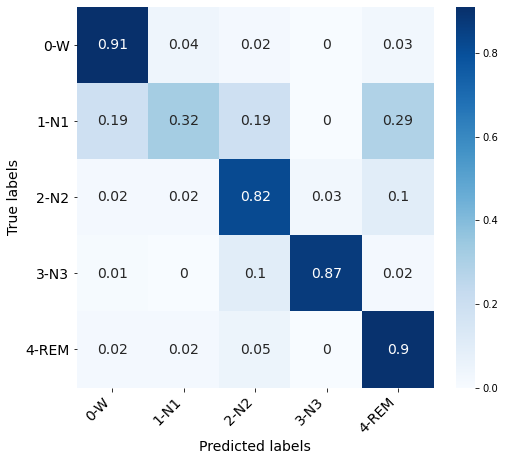

In [ ]:
# print confusion matrix

C = confusion_matrix( y_test ,y_pred)
cn = np.transpose( np.transpose(C) / C.astype(np.float).sum(axis=1) )
cn = np.round(cn, 2)

df_cm = pd.DataFrame(
    cn, index=['0-W','1-N1','2-N2','3-N3','4-REM'], columns=['0-W','1-N1','2-N2','3-N3','4-REM'])
fig = plt.figure(figsize=(8,7))
try:
    heatmap = sns.heatmap(df_cm, annot=True, cmap = "Blues", annot_kws={"size": 14})
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True labels', fontsize = 14)
plt.xlabel('Predicted labels',  fontsize=14)



# III. CNN + LSTM

The second network architecture to test in the dataset is an ensemble of CNN and LSTM, with rearrengement of feature vectors before the LSTM component, inspired from the proposed one in Supratak et al. (2017).

Please refer to the diagram below to review the details of the network. More explanation is provided in the papers. 

<img src='https://drive.google.com/uc?export=view&id=1LRjjSOkMmudf-V8I_o_GjnOrZ59aW-yK' alt="drawing" width="300"/>




In [22]:
def lstm_builder():

  inputs = keras.Input(shape=(5,2688))

  x = layers.Dropout(rate=0.5  , name ='lstm_dropout1' )(inputs)

  x1 = Bidirectional(layers.LSTM(512, return_sequences=True)) (x)
  x1 = layers.Dropout(rate=0.5  , name ='lstm_dropout2' )(x1)

  x1 = Bidirectional(layers.LSTM(512)) (x1)
  x1 = layers.Dropout(rate=0.5  , name ='lstm_dropout3' )(x1)

  x2 = layers.Dense(1024)(x)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU(name = 'lstm_residual1')(x2)

  addition = layers.Add(name = 'lstm_concat1')([x1, x2])


  x3 = layers.BatchNormalization()(addition)
  x3 = layers.ReLU(name = 'lstm_residual2')(x3)

  x3 = layers.Dropout(rate=0.5  , name ='lstm_dropout4' )(addition)

  x3 = layers.Flatten()(x3)

  outputs = layers.Dense(5, activation=tf.nn.softmax, name = 'lstm_soft') (x3)

  model_lstm = keras.Model(inputs=inputs, outputs=outputs, name='lstmsleep')

  return model_lstm


In [23]:
from tensorflow.keras.layers import Bidirectional #we will be needing this layer


# perform training and prediction for 20 stratified folds


skf = StratifiedKFold(n_splits=5) #10 - 20

cv_results = []
k = 0
for train_index,test_index in skf.split(X, Y):
  begin_time_loop = dt.now()
  print('Current time: {}'.format(str(begin_time_loop)))

  k = k+1
  X_train,X_test=X[train_index],X[test_index]
  y_train,y_test=Y[train_index],Y[test_index]


  #CNN
  model = cnn_builder( model_type = 'CNN+LSTM')

  model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
  
  history1 = model.fit(X_train, y_train,
                    batch_size=100,
                    epochs=19, verbose=0) # 24


  #get feature vectors
  layer_name = 'concat'
  intermediate_layer_model = keras.Model(inputs=model.input,
                                  outputs=model.get_layer(layer_name).output)
  intermediate_output_train = intermediate_layer_model.predict(X_train)
  intermediate_output_test = intermediate_layer_model.predict(X_test)
  X_train_lstm = intermediate_output_train
  X_test_lstm = intermediate_output_test

  a = np.zeros((1, 2688))

  X_train_lstm = np.insert(X_train_lstm, 0, a, axis=0)
  X_train_lstm = np.insert(X_train_lstm, 0, a, axis=0)
  X_train_lstm = np.insert(X_train_lstm, -1, a, axis=0)
  X_train_lstm = np.insert(X_train_lstm, -1, a, axis=0)

  X_test_lstm = np.insert(X_test_lstm, 0, a, axis=0)
  X_test_lstm = np.insert(X_test_lstm, 0, a, axis=0)
  X_test_lstm = np.insert(X_test_lstm, -1, a, axis=0)
  X_test_lstm = np.insert(X_test_lstm, -1, a, axis=0)

  X_train_lstm2 = []
  for i in range(len(X_train_lstm)-4):
    j = i + 2
    clip = np.array([X_train_lstm[j-2], X_train_lstm[j-1], X_train_lstm[j], X_train_lstm[j+1], X_train_lstm[j+2]])
    X_train_lstm2.append(clip)

  X_test_lstm2 = []
  for i in range(len(X_test_lstm)-4):
    j = i + 2
    clip = np.array([X_test_lstm[j-2], X_test_lstm[j-1], X_test_lstm[j], X_test_lstm[j+1], X_test_lstm[j+2]])
    X_test_lstm2.append(clip)

  X_train_lstm3=np.array(X_train_lstm2)
  X_test_lstm3=np.array(X_test_lstm2)

  #LSTM
  lstm = lstm_builder()

  lstm.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

  history2 = lstm.fit(X_train_lstm3, y_train,
                      batch_size=100,
                      epochs=5, verbose=0) # 
                      
  test_scores = lstm.evaluate(X_test_lstm3, y_test, verbose=0)
  print('Test accuracy:', test_scores[1])  

  y_prob = lstm.predict(X_test_lstm3)

  y_pred = y_prob.argmax(axis=-1)

  elapsed = dt.now() - begin_time_loop
  print('Fold {} took {}'.format(str(k), str(elapsed)))
  
  fold_result = {'fold': k, 'time': elapsed,'y_test': y_test, 'y_pred': y_pred, 'y_prob': y_prob,
               'history_cnn': history1.history, 'history_lstm': history2.history,  'accuracy': test_scores[1] }
    
      
  cv_results.append(fold_result)


Current time: 2020-11-12 04:52:51.536660
Test accuracy: 0.8850153684616089
Fold 1 took 0:02:03.094468
Current time: 2020-11-12 04:54:54.632062
Test accuracy: 0.7987473607063293
Fold 2 took 0:02:02.720444
Current time: 2020-11-12 04:56:57.353280
Test accuracy: 0.8520444631576538
Fold 3 took 0:02:02.410019
Current time: 2020-11-12 04:58:59.763968
Test accuracy: 0.8306346535682678
Fold 4 took 0:02:03.880290
Current time: 2020-11-12 05:01:03.645019
Test accuracy: 0.8501359224319458
Fold 5 took 0:02:03.663343


In [24]:

import pickle

path = '/content/gdrive/My Drive/Automatic_sleep_classification/results/cnnlstm.pkl'

with open(path, 'wb') as f:
    pickle.dump(cv_results, f)

# unravel y_pred and y_test into unique vectors for classification report
y_pred=[]
y_test=[]
for i in cv_results:
  y_pred.extend(i['y_pred'])
  y_test.extend(i['y_test']) 


print(classification_report(y_test,y_pred, digits=4) )

## accuracy is higher when trained around 20 folds


              precision    recall  f1-score   support

           0     0.8318    0.9164    0.8720      8285
           1     0.4246    0.3959    0.4097      2804
           2     0.8880    0.8812    0.8846     17799
           3     0.9002    0.8874    0.8938      5703
           4     0.8557    0.8074    0.8309      7717

    accuracy                         0.8433     42308
   macro avg     0.7801    0.7777    0.7782     42308
weighted avg     0.8420    0.8433    0.8421     42308



Text(0.5, 42.0, 'Predicted labels')

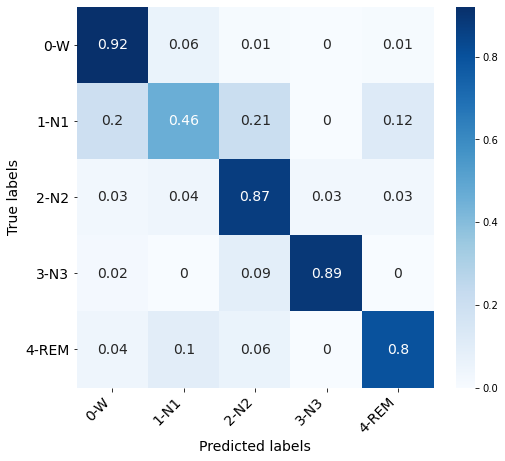

In [9]:
# print confusion matrix

C = confusion_matrix( y_test ,y_pred)
cn = np.transpose( np.transpose(C) / C.astype(np.float).sum(axis=1) )
cn = np.round(cn, 2)

df_cm = pd.DataFrame(
    cn, index=['0-W','1-N1','2-N2','3-N3','4-REM'], columns=['0-W','1-N1','2-N2','3-N3','4-REM'])
fig = plt.figure(figsize=(8,7))
try:
    heatmap = sns.heatmap(df_cm, annot=True, cmap = "Blues", annot_kws={"size": 14})
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True labels', fontsize = 14)
plt.xlabel('Predicted labels',  fontsize=14)



In [10]:
#average time of training+prediction per fold

elapsed_t = []
for i in cv_results:
  elapsed_t.append(i['time'])

elapsed_t = pd.Series(elapsed_t)
elapsed_t.mean()


Timedelta('0 days 00:02:03.454756600')

In [11]:
#if data neews to be uploaded again, this cell helps

import pickle
with open('/content/gdrive/My Drive/Automatic_sleep_classification/results/cnnlstm.pkl', 'rb') as f:
    data = pickle.load(f)

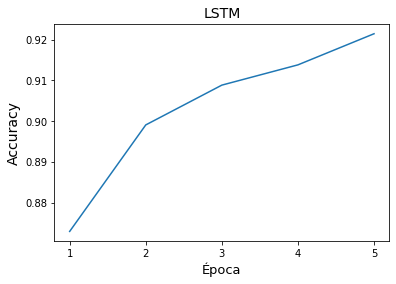

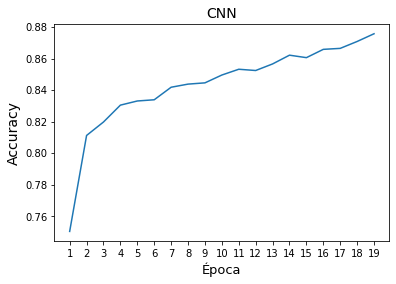

In [13]:
# plot accuracy curves per training epoch. Uncomment lines if want figures to be saved
accuracies = []
accuracies.extend(data[3]['history_cnn']['accuracy'])
accuracies.extend(data[3]['history_lstm']['accuracy'])

plt.plot(data[3]['history_lstm']['accuracy'])
plt.title('LSTM', fontsize =14)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Época' , fontsize=13)
plt.xticks(ticks = np.arange(0, 5, step=1),  labels =  np.arange(1, 6, step=1))
#plt.savefig( 'fill-with-path' ,bbox_inches='tight')
plt.show()

plt.plot(data[3]['history_cnn']['accuracy'])
plt.title('CNN', fontsize =14)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Época' , fontsize=13)
plt.xticks(ticks = np.arange(0, 19, step=1),  labels =  np.arange(1, 20, step=1))
#plt.savefig( 'fill-with-path' ,bbox_inches='tight')
plt.show()


# IV. Hypnogram comparison

In this section we want to use the classifier to predict only one of the sleep recordings and use the rest of the recordings as training set. Then we will compare the predicted hypnogram of this sleep recording to the real one, to obtain a visual comparison of the predictions, similar to what a doctor would use.

In [26]:
import random
import datetime
path = '/content/gdrive/My Drive/Automatic_sleep_classification/data' 
files = os.listdir(path)
filespath = [] #lista de archivos npz
for i in files:
  filespath.append(os.path.join(path,i))


def one_record_test_set(filespath,i):

  files = filespath[:]
  test_record = files.pop(i)
  print('Using record {} as test set'.format(test_record))

  X_test, y_test = _load_npz_list_files([test_record])
  X_train, y_train = _load_npz_list_files(files)

  print(X_test.shape, y_test.shape, X_train.shape, y_train.shape)

  return X_train, X_test, y_train, y_test, test_record

cv_results = []

for i in range(1):
  i =  -7 #we select this recording because it produces an accuracy score comparable to the general accuracy when trained with cross val
  X_train, X_test, y_train, y_test, record = one_record_test_set(filespath, i) 

  begin_time_loop = datetime.datetime.now()
  print('Current time: {}'.format(str(begin_time_loop)))

    #CNN

  model = cnn_builder(model_type = 'CNN+LSTM')

  model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
  
  history1 = model.fit(X_train, y_train,
                    batch_size=100,
                    epochs=19, verbose=0) # 24


  #get feature vectors
  layer_name = 'concat'
  intermediate_layer_model = keras.Model(inputs=model.input,
                                  outputs=model.get_layer(layer_name).output)
  intermediate_output_train = intermediate_layer_model.predict(X_train)
  intermediate_output_test = intermediate_layer_model.predict(X_test)
  X_train_lstm = intermediate_output_train
  X_test_lstm = intermediate_output_test


  a = np.zeros((1, 2688))

  X_train_lstm = np.insert(X_train_lstm, 0, a, axis=0)
  X_train_lstm = np.insert(X_train_lstm, 0, a, axis=0)
  X_train_lstm = np.insert(X_train_lstm, -1, a, axis=0)
  X_train_lstm = np.insert(X_train_lstm, -1, a, axis=0)

  X_test_lstm = np.insert(X_test_lstm, 0, a, axis=0)
  X_test_lstm = np.insert(X_test_lstm, 0, a, axis=0)
  X_test_lstm = np.insert(X_test_lstm, -1, a, axis=0)
  X_test_lstm = np.insert(X_test_lstm, -1, a, axis=0)

  X_train_lstm2 = []
  for i in range(len(X_train_lstm)-4):
    j = i + 2
    clip = np.array([X_train_lstm[j-2], X_train_lstm[j-1], X_train_lstm[j], X_train_lstm[j+1], X_train_lstm[j+2]])
    X_train_lstm2.append(clip)

  X_test_lstm2 = []
  for i in range(len(X_test_lstm)-4):
    j = i + 2
    clip = np.array([X_test_lstm[j-2], X_test_lstm[j-1], X_test_lstm[j], X_test_lstm[j+1], X_test_lstm[j+2]])
    X_test_lstm2.append(clip)

  X_train_lstm3=np.array(X_train_lstm2)
  X_test_lstm3=np.array(X_test_lstm2)

  #LSTM
  lstm = lstm_builder()

  lstm.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

  history2 = lstm.fit(X_train_lstm3, y_train,
                      batch_size=100,
                      epochs=5, verbose=0) # 
                      
  test_scores = lstm.evaluate(X_test_lstm3, y_test, verbose=0)
  print('Test accuracy:', test_scores[1])  

  y_prob = lstm.predict(X_test_lstm3)

  y_pred = y_prob.argmax(axis=-1)

  elapsed = datetime.datetime.now() - begin_time_loop
  print('Fold {} took {}'.format(str(1), str(elapsed)))
  
  fold_result = {'record': record, 'time': elapsed,'y_test': y_test, 'y_pred': y_pred, 'accuracy': test_scores[1] }
    
      
  cv_results.append(fold_result)
 
 # 0.8341862559318542

Using record /content/gdrive/My Drive/Automatic_sleep_classification/data/SC4122E0.npz as test set
(977, 3000, 1) (977,) (41331, 3000, 1) (41331,)
Current time: 2020-11-12 05:09:15.657266
Test accuracy: 0.8311156630516052
Fold 1 took 0:02:24.776364


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


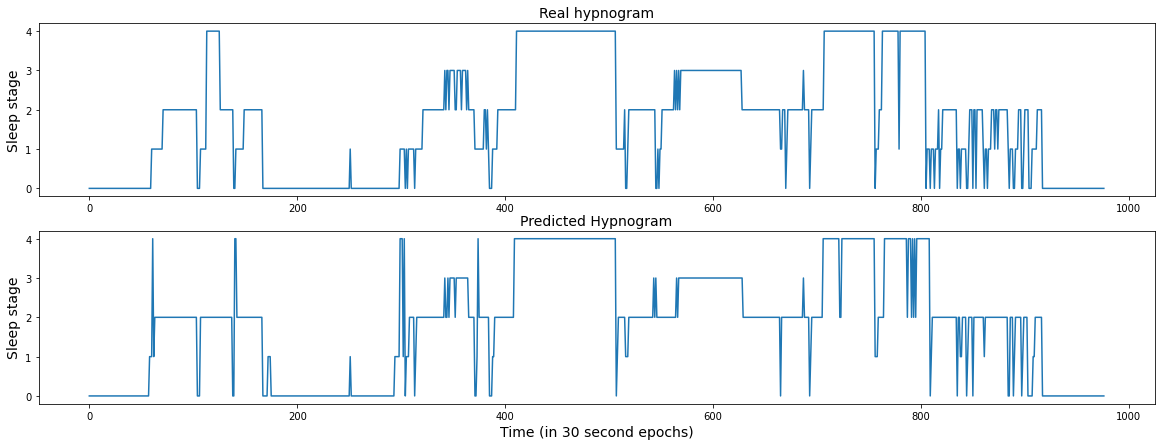

In [27]:
y_pred = cv_results[0]['y_pred']
y_test = cv_results[0]['y_test']

from seaborn import lineplot

fig, axs = plt.subplots(2,1, figsize=(20,7))

axs[0].set_title('Real hypnogram', size = 14)
axs[0].set_ylabel('Sleep stage', fontsize=14)
axs[0].set_yticks([0,1,2,3,4])


axs[1].set_title('Predicted Hypnogram', size = 14)
axs[1].set_ylabel('Sleep stage', fontsize=14)
axs[1].set_yticks([0,1,2,3,4])

axs[1].set_xlabel('Time (in 30 second epochs)', fontsize=14)

sns.lineplot(np.arange(len(y_test)), y_test, ax = axs[0])
sns.lineplot(np.arange(len(y_pred)), y_pred, ax = axs[1])


# fig.savefig('fill-with-path',bbox_inches='tight')
